In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [303]:
import re
import nltk
import string
import random
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

In [3]:
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load data

In [4]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/drug_dataset.csv')
df = pd.DataFrame(df)
df['title']

0                       Why is this medication prescribed?
1                        How should this medicine be used?
2                             Other uses for this medicine
3                What special precautions should I follow?
4        What special dietary instructions should I fol...
                               ...                        
17738                What other information should I know?
17739                                          Brand names
17740                        In case of emergency/overdose
17741                What other information should I know?
17742                                          Brand names
Name: title, Length: 17743, dtype: object

# Take unique titles

In [5]:
titles_sentences = set(df['title'].str.lower())
titles_sentences = list(titles_sentences)
len(titles_sentences)

136

# Analyze Our Vocabulary 

In [6]:
stemmer = nltk.stem.SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [7]:
titles_word_list = [] 
titles_sentence_list = []
titles_stemmed_sentence_list = []
titles_stemmed_words = []
punc_digit_pattern = '\W+|\d+'

for titles_sentence in titles_sentences:
    titles_sentence = re.sub(punc_digit_pattern, ' ', titles_sentence)
    titles_word_in_sentence = nltk.word_tokenize(titles_sentence)
    titles_word_in_sentence = [word for word in titles_word_in_sentence if len(word) > 1]
    titles_stemmed_words_in_sentence = [stemmer.stem(lemmatizer.lemmatize(word)) for word in titles_word_in_sentence]
    titles_sentence_list.append(titles_word_in_sentence)
    titles_word_list += titles_word_in_sentence 
    titles_stemmed_sentence_list.append(titles_stemmed_words_in_sentence)
    titles_stemmed_words += titles_stemmed_words_in_sentence 

len(titles_word_list)

824

In [8]:
titles_word_set = list(set(titles_word_list))
titles_stemmed_word_set = list(set(titles_stemmed_words))
len(titles_word_set)

164

In [9]:
len(titles_stemmed_word_set)

156

In [10]:
stop_words = set(stopwords.words('english'))

In [12]:
titles_common_words = [word for word in titles_word_set if word in stop_words]
titles_rare_words = [word for word in titles_word_set if word not in stop_words]
titles_stemmed_common_words = [word for word in titles_stemmed_word_set if word in stop_words]
titles_stemmed_rare_words = [word for word in titles_stemmed_word_set if word not in stop_words]

print(f"Number of unique words: {len(titles_word_set)}\n\
Number of stop words in our questions vocabulary: {len(titles_common_words)}\n\
Number of rare words in our questions vocabulary: {len(titles_rare_words)}\n\
Number of stemmed stop words in our questions vocabulary: {len(titles_stemmed_common_words)}\n\
Number of stemmed rare words in our questions vocabulary: {len(titles_stemmed_rare_words)}")

Number of unique words: 164
Number of stop words in our questions vocabulary: 37
Number of rare words in our questions vocabulary: 127
Number of stemmed stop words in our questions vocabulary: 36
Number of stemmed rare words in our questions vocabulary: 120


(array([363., 153.,  67.,  47.,  36.,  51.,  32.,  31.,  25.,  19.]),
 array([  0. ,  16.3,  32.6,  48.9,  65.2,  81.5,  97.8, 114.1, 130.4,
        146.7, 163. ]),
 <a list of 10 Patch objects>)

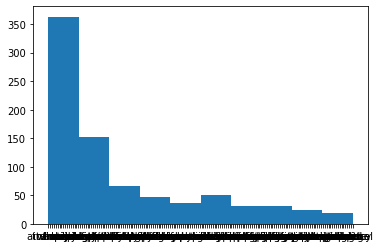

In [415]:
plt.hist(titles_word_list)

(array([18., 10., 14., 13., 13., 31.,  9., 13., 10.,  5.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

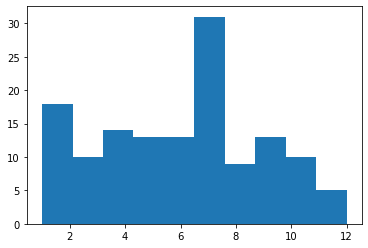

In [423]:
titles_sentence_legth_dist = [len(title) for title in titles_stemmed_sentence_list]
plt.hist(titles_sentence_legth_dist)

## Pretrained Word2Vec

In [ ]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
out_of_vocabulary = ['laiv', 'pcv', 'ipv', 'ppsv', 'moderna', 'mmr', 'covid', 'tdap', 'biontech', 'hib', 'janssen', 'dtap']
titles_rare_vectors = [word2vec_model[rare_word] for rare_word in titles_rare_words if rare_word not in out_of_vocabulary]
titles_rare_vectors = np.array(titles_rare_vectors)

In [ ]:
titles_rare_vectors.shape

(115, 300)

In [ ]:
pca = PCA(n_components=2)
titles_reduced_data = pca.fit_transform(titles_rare_vectors)
titles_reduced_data.shape

(115, 2)

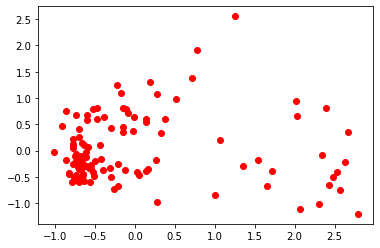

In [ ]:
plt.scatter(titles_reduced_data.T[0], titles_reduced_data.T[1], marker='o', color='r')

## Training Word2Vec Model

In [14]:
titles_trained_model = Word2Vec(size=300, window=5, min_count=1)
titles_trained_model.build_vocab(titles_stemmed_sentence_list)
titles_trained_model.train(titles_stemmed_sentence_list, total_examples=titles_trained_model.corpus_count, epochs=1000)

(346523, 824000)

In [15]:
titles_trained_model.save("titles_word2vec.model")

In [16]:
!mv titles_word2vec.model drive/MyDrive/

In [55]:
titles_rare_vectors = [titles_trained_model.wv[word] for word in titles_stemmed_rare_words]
titles_rare_vectors = np.array(titles_rare_vectors)

## Visulize all questions words with trained model on all questions

In [56]:
pca = PCA(n_components=2)
titles_reduced_data = pca.fit_transform(titles_rare_vectors)
titles_reduced_data.shape

(120, 2)

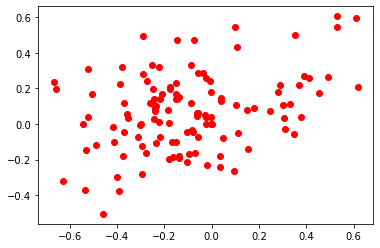

In [57]:
plt.scatter(titles_rare_vectors.T[0], titles_rare_vectors.T[1], marker='o', color='r')

### Note: It seems the trained word2vec model gets a better results than the pre-trained one on medicine documents. 
### So we will cluster vectors on trained one/

## Vocabulary clustering

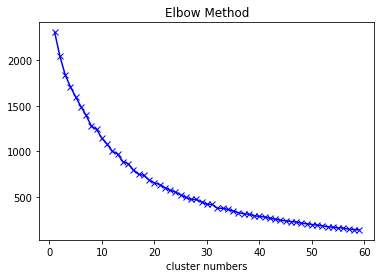

In [20]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(titles_rare_vectors)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [21]:
n_clusters = 30

km = KMeans(n_clusters=n_clusters)

km.fit(titles_rare_vectors)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  30  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [22]:
clusters = {}

for i, word in enumerate(titles_stemmed_rare_words):
    if km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0]] = [word]

clusters

{0: ['case', 'overdos'],
 1: ['import',
  'relat',
  'rotavirus',
  'vaccin',
  'drug',
  'enceph',
  'japanes',
  'mmr',
  'diseas',
  'chickenpox',
  'reaction',
  'avail',
  'topic',
  'notic',
  'warn'],
 2: ['covid', 'moderna', 'pfizer', 'biontech'],
 3: ['hpv', 'td', 'tdap', 'hib'],
 4: ['nasal', 'live', 'shingl', 'attenu', 'laiv', 'influenza', 'spray'],
 5: ['serious', 'moder', 'problem', 'sever'],
 6: ['storag', 'dispos', 'know'],
 7: ['countermeasur', 'injuri', 'program', 'compens', 'nation'],
 8: ['doctor',
  'provid',
  'treatment',
  'card',
  'talk',
  'health',
  'keep',
  'care'],
 9: ['follow', 'precaut', 'instruct', 'special', 'dietari'],
 10: ['administr', 'fee', 'charg'],
 11: ['forget', 'dose'],
 12: ['brand', 'brows', 'generic'],
 13: ['caus', 'effect', 'side'],
 14: ['yellow', 'prevent', 'learn', 'fever'],
 15: ['person', 'tell'],
 16: ['dtap', 'babi', 'peopl', 'child'],
 17: ['medicin', 'prescrib', 'use', 'medic', 'whi', 'us'],
 18: ['johnson', 'janssen'],
 19: [

<BarContainer object of 30 artists>

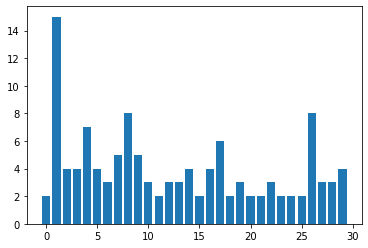

In [23]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

# Analyze Our Documents

In [299]:
df['text'].isnull().sum()

2


In [195]:
df['title'].isnull().sum()

0

In [196]:
df[df['text'].isnull()]

,Section_Number,Link,drug_name,title,text,documents


In [197]:
df['documents'] = df['title'] + df['text']
df.loc[10]['documents']

'What special precautions should I follow?Before receiving famotidine injection,tell your doctor and pharmacist if you are allergic to famotidine, cimetidine, nizatidine (Axid), ranitidine (Zantac), any other medications, or any of the ingredients in famotidine injection. Ask your pharmacist for a list of the ingredients.tell your doctor and pharmacist what other prescription and nonprescription medications, vitamins, nutritional supplements, and herbal products you are taking or plan to take. Your doctor may need to change the doses of your medications or monitor you carefully for side effects.tell your doctor if you have or have ever had kidney disease.tell your doctor if you are pregnant, plan to become pregnant, or are breast-feeding. If you become pregnant while receiving famotidine injection, call your doctor.'

In [198]:
df.dropna(subset=['documents'], inplace=True)

In [199]:
df['documents'].isnull().sum()

0

In [200]:
documents = set(df['documents'].str.lower())
documents = list(documents)

print(f"We have {len(documents)} unique question-answer pair in our dataset")

We have 12709 unique question-answer pair in our dataset


In [202]:
documents_sentences = []

for document in documents:
  sentence_in_doc = nltk.sent_tokenize(document)
  documents_sentences += sentence_in_doc

documents_sentences = list(set(documents_sentences))
print(f"We have {len(documents_sentences)} unique sentence in our dataset")

We have 49020 unique sentence in our dataset


In [226]:
documents_word_list = [] 
documents_sentence_list = []
documents_stemmed_sentence_list = []
documents_stemmed_words = []
punc_digit_pattern = '\W+|\d+'

for documents_sentence in documents_sentences:
    documents_sentence = re.sub(punc_digit_pattern, ' ', documents_sentence)
    documents_word_in_sentence = nltk.word_tokenize(documents_sentence)
    documents_word_in_sentence = [word for word in documents_word_in_sentence if len(word) > 1]
    documents_stemmed_words_in_sentence = [stemmer.stem(lemmatizer.lemmatize(word)) for word in documents_word_in_sentence]
    documents_sentence_list.append(documents_word_in_sentence)
    documents_word_list += documents_word_in_sentence 
    documents_stemmed_sentence_list.append(documents_stemmed_words_in_sentence)
    documents_stemmed_words += documents_stemmed_words_in_sentence 

len(documents_word_list)

1493466

In [227]:
documents_word_set = list(set(documents_word_list))
documents_stemmed_word_set = list(set(documents_stemmed_words))

print(f"We have {len(documents_word_set)} unique words in our dataset\n\
We have {len(documents_stemmed_word_set)} unique stemmed words in our dataset")

We have 26586 unique words in our dataset
We have 23859 unique stemmed words in our dataset


In [228]:
documents_common_words = [word for word in documents_word_set if word in stop_words]
documents_rare_words = [word for word in documents_word_set if word not in stop_words]
documents_stemmed_common_words = [word for word in documents_stemmed_word_set if word in stop_words]
documents_stemmed_rare_words = [word for word in documents_stemmed_word_set if word not in stop_words]

print(f"Number of unique words: {len(documents_word_set)}\n\
Number of stop words in our document vocabulary: {len(documents_common_words)}\n\
Number of rare words in our document vocabulary: {len(documents_rare_words)}\n\
Number of stemmed stop words in our document vocabulary: {len(documents_stemmed_common_words)}\n\
Number of stemmed rare words in our document vocabulary: {len(documents_stemmed_rare_words)}")

Number of unique words: 26586
Number of stop words in our document vocabulary: 122
Number of rare words in our document vocabulary: 26464
Number of stemmed stop words in our document vocabulary: 109
Number of stemmed rare words in our document vocabulary: 23750


(array([1341566.,   81282.,   28371.,   14572.,    8506.,    5427.,
           4342.,    3478.,    3131.,    2791.]),
 array([    0. ,  2658.5,  5317. ,  7975.5, 10634. , 13292.5, 15951. ,
        18609.5, 21268. , 23926.5, 26585. ]),
 <a list of 10 Patch objects>)

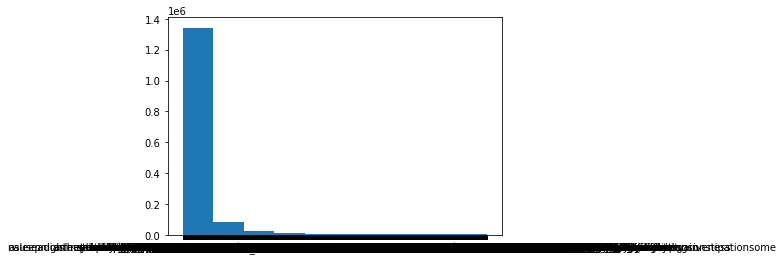

In [416]:
plt.hist(documents_word_list)

(array([4.8825e+04, 1.7400e+02, 1.5000e+01, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   0. ,  162.5,  325. ,  487.5,  650. ,  812.5,  975. , 1137.5,
        1300. , 1462.5, 1625. ]),
 <a list of 10 Patch objects>)

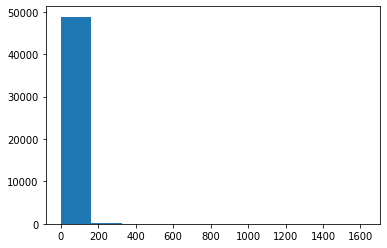

In [431]:
documents_sentence_legth_dist = [len(title) for title in documents_stemmed_sentence_list]
plt.hist(documents_sentence_legth_dist)

In [443]:
len(documents_sentence_legth_dist)

49020

(array([ 6001., 13453.,  9814.,  7791.,  4446.,  2931.,  1569.,   936.,
          592.,   467.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

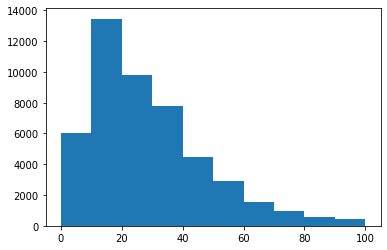

In [450]:
documents_sentence_legth_dist.sort()
plt.hist(documents_sentence_legth_dist[:48000])

## Training Word2Vec on documents

In [405]:
documents_trained_model = Word2Vec(size=300, window=5, min_count=1)
documents_trained_model.build_vocab(documents_stemmed_sentence_list)
documents_trained_model.train(documents_stemmed_sentence_list, total_examples=documents_trained_model.corpus_count, epochs=2000)

In [403]:
documents_trained_model.save("documents_word2vec.model")

In [404]:
!mv documents_word2vec.model drive/MyDrive/

In [229]:
documents_rare_vectors = [documents_trained_model.wv[word] for word in documents_stemmed_rare_words]
documents_rare_vectors = np.array(documents_rare_vectors)

## Visulize all documents words with trained model on all documents

In [230]:
pca = PCA(n_components=2)
documents_reduced_data = pca.fit_transform(documents_rare_vectors)
documents_reduced_data.shape

(23750, 2)

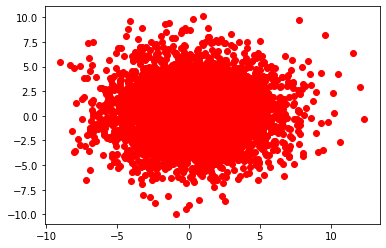

In [231]:
plt.scatter(documents_rare_vectors.T[0], documents_rare_vectors.T[1], marker='o', color='r')

## Visulize all question words with trained model on all documents

In [232]:
titles_rare_vectors = [documents_trained_model.wv[word] for word in titles_stemmed_rare_words]
titles_rare_vectors = np.array(titles_rare_vectors)

In [233]:
pca = PCA(n_components=2)
titles_reduced_data = pca.fit_transform(titles_rare_vectors)
titles_reduced_data.shape

(120, 2)

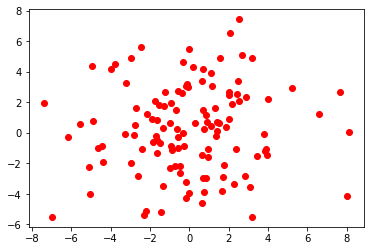

In [234]:
plt.scatter(titles_rare_vectors.T[0], titles_rare_vectors.T[1], marker='o', color='r')

## Vocabulary clustering with Word2Vec model trained on all documents

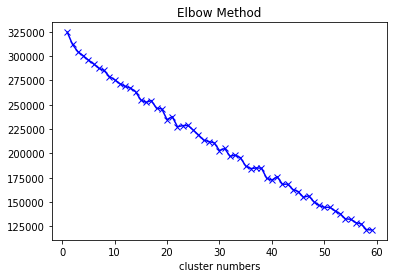

In [203]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(titles_rare_vectors)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [235]:
n_clusters = 30

km = KMeans(n_clusters=n_clusters)

km.fit(titles_rare_vectors)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  30  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [236]:
clusters = {}

for i, word in enumerate(titles_stemmed_rare_words):
    if km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(titles_rare_vectors[i].reshape(-1, 1).T)[0]] = [word]

# clusters

<BarContainer object of 30 artists>

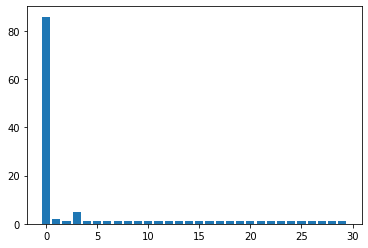

In [237]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Normalizing embedding vectors. Result will be the same as **cosine similarities**

In [238]:
titles_rare_vectors_norm = normalize(titles_rare_vectors, axis=1)
titles_rare_vectors_norm.shape

(120, 300)

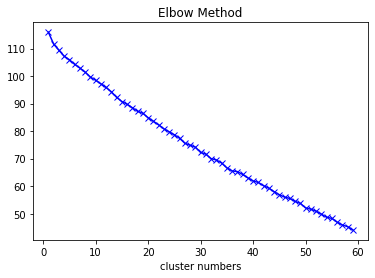

In [239]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(titles_rare_vectors_norm)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [240]:
n_clusters = 30

km = KMeans(n_clusters=n_clusters)

km.fit(titles_rare_vectors_norm)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  30  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [241]:
clusters = {}

for i, word in enumerate(titles_stemmed_rare_words):
    if km.predict(titles_rare_vectors_norm[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(titles_rare_vectors_norm[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(titles_rare_vectors_norm[i].reshape(-1, 1).T)[0]] = [word]

# clusters

<BarContainer object of 30 artists>

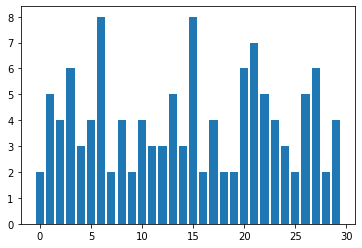

In [242]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Dimensionality reduction on word embedding results

In [272]:
pca = PCA(n_components=0.60, svd_solver='full')
reduced_data = pca.fit_transform(titles_rare_vectors)

In [273]:
reduced_data.shape

(120, 30)

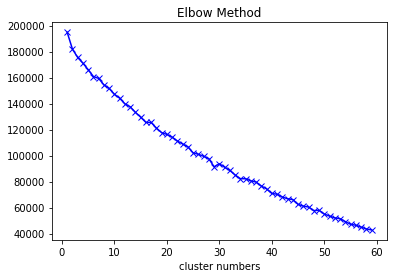

In [274]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [287]:
n_clusters = 20

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  20  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 20, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [288]:
clusters = {}

for i, word in enumerate(titles_stemmed_rare_words):
    if km.predict(reduced_data[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]] = [word]

# clusters

<BarContainer object of 20 artists>

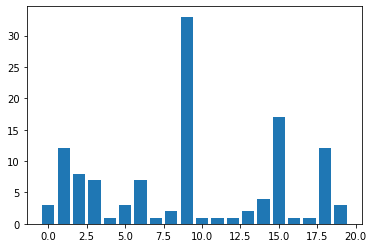

In [289]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Combinition of dimensionality reduction and normalization on word embedding results

In [290]:
titles_rare_vectors_norm = normalize(titles_rare_vectors, axis=1)

pca = PCA(n_components=0.60, svd_solver='full')
reduced_data_norm = pca.fit_transform(titles_rare_vectors_norm)

reduced_data_norm.shape

(120, 33)

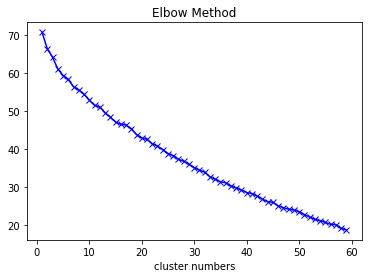

In [291]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data_norm)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [296]:
n_clusters = 20

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data_norm)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  20  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 20, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


<BarContainer object of 20 artists>

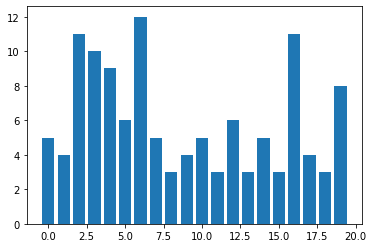

In [297]:
clusters = {}

for i, word in enumerate(titles_stemmed_rare_words):
    if km.predict(reduced_data_norm[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(reduced_data_norm[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(reduced_data_norm[i].reshape(-1, 1).T)[0]] = [word]

# clusters

plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Hierarchical Clustering on Word2Vec model trained on titles list

In [222]:
titles_rare_vectors = [titles_trained_model.wv[word] for word in titles_stemmed_rare_words]
titles_rare_vectors = np.array(titles_rare_vectors)

In [214]:
model = AgglomerativeClustering(n_clusters=30)
model = model.fit(titles_rare_vectors)

In [215]:
clusters = {}

for i, label in enumerate(model.labels_):
    if label in clusters.keys():
      clusters[label].append(titles_stemmed_rare_words[i])
    else:
      clusters[label] = [titles_stemmed_rare_words[i]]

clusters

{0: ['je',
  'ipv',
  'hpv',
  'td',
  'anthrax',
  'hepat',
  'tdap',
  'hib',
  'meningococc',
  'group',
  'rabi',
  'polio',
  'typhoid'],
 1: ['nasal', 'live', 'shingl', 'attenu', 'laiv', 'influenza', 'spray'],
 2: ['import', 'relat', 'enceph', 'japanes', 'topic', 'warn'],
 3: ['serious', 'moder', 'reaction', 'problem', 'sever'],
 4: ['brand', 'brows', 'combin', 'generic', 'product', 'name'],
 5: ['doctor',
  'provid',
  'treatment',
  'card',
  'talk',
  'health',
  'keep',
  'care'],
 6: ['prescrib', 'medic', 'whi'],
 7: ['get', 'wait'],
 8: ['risk', 'benefit'],
 9: ['rotavirus',
  'vaccin',
  'drug',
  'mmr',
  'diseas',
  'chickenpox',
  'avail',
  'notic'],
 10: ['countermeasur', 'injuri', 'program', 'compens', 'nation'],
 11: ['yellow', 'fever'],
 12: ['medicin', 'use', 'us'],
 13: ['emerg', 'suspect', 'case', 'fraud', 'overdos', 'report'],
 14: ['covid', 'give', 'given'],
 15: ['person', 'tell'],
 16: ['inform', 'record'],
 17: ['caus', 'effect', 'side'],
 18: ['administr',

<BarContainer object of 30 artists>

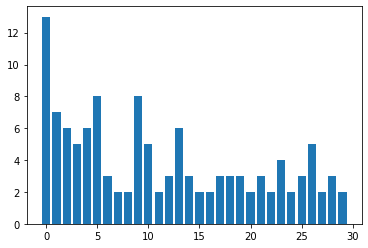

In [216]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Hierarchical Clustering on Word2Vec model trained on titles list - Cosine Similarities

In [223]:
model = AgglomerativeClustering(n_clusters=30, affinity='cosine', linkage='average')
model = model.fit(titles_rare_vectors)

In [224]:
clusters = {}

for i, label in enumerate(model.labels_):
    if label in clusters.keys():
      clusters[label].append(titles_stemmed_rare_words[i])
    else:
      clusters[label] = [titles_stemmed_rare_words[i]]

clusters

{0: ['rotavirus', 'ppsv', 'mmr', 'chickenpox', 'polysaccharid', 'pneumococc'],
 1: ['import', 'relat', 'topic'],
 2: ['dtap', 'get', 'babi', 'wait', 'peopl', 'child'],
 3: ['administr', 'fee', 'cholera', 'pcv', 'charg', 'receiv'],
 4: ['risk', 'avail', 'benefit'],
 5: ['nasal',
  'live',
  'inactiv',
  'shingl',
  'attenu',
  'laiv',
  'influenza',
  'recombin',
  'spray'],
 6: ['serious', 'moder', 'reaction', 'problem', 'sever'],
 7: ['emerg', 'suspect', 'case', 'fraud', 'overdos', 'report'],
 8: ['caus', 'effect', 'side', 'medic'],
 9: ['je',
  'ipv',
  'hpv',
  'td',
  'anthrax',
  'hepat',
  'tdap',
  'hib',
  'meningococc',
  'group',
  'rabi',
  'typhoid'],
 10: ['covid',
  'give',
  'moderna',
  'pfizer',
  'johnson',
  'biontech',
  'janssen',
  'given'],
 11: ['prescrib', 'whi'],
 12: ['medicin', 'use', 'us'],
 13: ['storag', 'dispos', 'know'],
 14: ['yellow', 'fever'],
 15: ['vaccin'],
 16: ['person', 'tell'],
 17: ['inform', 'record'],
 18: ['brand', 'brows', 'combin', 'gene

<BarContainer object of 30 artists>

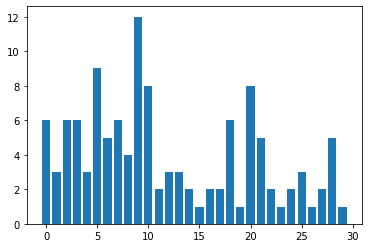

In [225]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Hierarchical Clustering on Word2Vec model trained on all documents

In [204]:
titles_rare_vectors = [documents_trained_model.wv[word] for word in titles_stemmed_rare_words]
titles_rare_vectors = np.array(titles_rare_vectors)

In [206]:
model = AgglomerativeClustering(n_clusters=30)
model = model.fit(titles_rare_vectors)

In [207]:
clusters = {}

for i, label in enumerate(model.labels_):
    if label in clusters.keys():
      clusters[label].append(titles_stemmed_rare_words[i])
    else:
      clusters[label] = [titles_stemmed_rare_words[i]]

clusters

{0: ['nasal',
  'live',
  'brand',
  'treatment',
  'countermeasur',
  'brows',
  'attenu',
  'herb',
  'combin',
  'fraud',
  'japanes',
  'record',
  'fee',
  'generic',
  'recombin',
  'spray',
  'compens',
  'name',
  'group',
  'dose',
  'charg',
  'nation',
  'topic',
  'use',
  'polysaccharid'],
 1: ['rotavirus', 'td', 'tdap', 'mmr', 'hib', 'chickenpox', 'pneumococc'],
 2: ['give', 'yellow', 'get', 'dispos', 'keep', 'notic', 'receiv', 'given'],
 3: ['import', 'card'],
 4: ['wait', 'forget', 'moder'],
 5: ['enceph', 'injuri', 'reaction'],
 6: ['doctor',
  'drug',
  'provid',
  'supplement',
  'follow',
  'product',
  'benefit',
  'medic'],
 7: ['covid',
  'je',
  'hpv',
  'anthrax',
  'shingl',
  'ppsv',
  'hepat',
  'cholera',
  'influenza',
  'meningococc',
  'rabi',
  'polio',
  'typhoid'],
 8: ['relat', 'care', 'report'],
 9: ['us'],
 10: ['caus', 'prevent', 'prescrib'],
 11: ['effect', 'side', 'dietari'],
 12: ['serious', 'suspect'],
 13: ['case', 'peopl', 'avail'],
 14: ['w

<BarContainer object of 30 artists>

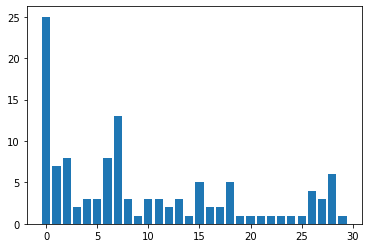

In [208]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Hierarchical Clustering on Word2Vec model trained on all documents - Cosine Similarities

In [219]:
model = AgglomerativeClustering(n_clusters=30, affinity='cosine', linkage='average')
model = model.fit(titles_rare_vectors)

In [220]:
clusters = {}

for i, label in enumerate(model.labels_):
    if label in clusters.keys():
      clusters[label].append(titles_stemmed_rare_words[i])
    else:
      clusters[label] = [titles_stemmed_rare_words[i]]

clusters

{0: ['rotavirus', 'ppsv', 'mmr', 'chickenpox', 'polysaccharid', 'pneumococc'],
 1: ['import', 'relat', 'topic'],
 2: ['dtap', 'get', 'babi', 'wait', 'peopl', 'child'],
 3: ['administr', 'fee', 'cholera', 'pcv', 'charg', 'receiv'],
 4: ['risk', 'avail', 'benefit'],
 5: ['nasal',
  'live',
  'inactiv',
  'shingl',
  'attenu',
  'laiv',
  'influenza',
  'recombin',
  'spray'],
 6: ['serious', 'moder', 'reaction', 'problem', 'sever'],
 7: ['emerg', 'suspect', 'case', 'fraud', 'overdos', 'report'],
 8: ['caus', 'effect', 'side', 'medic'],
 9: ['je',
  'ipv',
  'hpv',
  'td',
  'anthrax',
  'hepat',
  'tdap',
  'hib',
  'meningococc',
  'group',
  'rabi',
  'typhoid'],
 10: ['covid',
  'give',
  'moderna',
  'pfizer',
  'johnson',
  'biontech',
  'janssen',
  'given'],
 11: ['prescrib', 'whi'],
 12: ['medicin', 'use', 'us'],
 13: ['storag', 'dispos', 'know'],
 14: ['yellow', 'fever'],
 15: ['vaccin'],
 16: ['person', 'tell'],
 17: ['inform', 'record'],
 18: ['brand', 'brows', 'combin', 'gene

<BarContainer object of 30 artists>

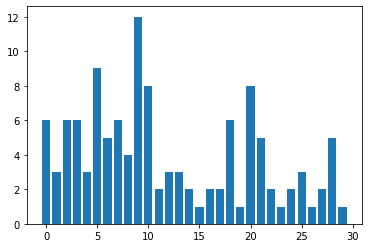

In [221]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

# Questions Clustering

## Randomly choose 30 samples of a data

In [327]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [328]:
sentence_embeddings = model.encode(titles_sentences)

In [329]:
# sentence_embeddings[0]
sentence_embeddings.shape

(136, 768)

## Without dimensionality reduction

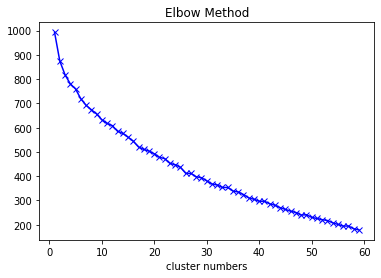

In [330]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(sentence_embeddings)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [331]:
# Hyperparameter 1
n_clusters = 7

km = KMeans(n_clusters=n_clusters)

km.fit(sentence_embeddings)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  7  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 7, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [350]:
clusters = {}

for i, titles_sentence in enumerate(titles_sentences):
    if km.predict(sentence_embeddings[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(sentence_embeddings[i].reshape(-1, 1).T)[0]].append(titles_sentence)
    else:
      clusters[km.predict(sentence_embeddings[i].reshape(-1, 1).T)[0]] = [titles_sentence]

clusters

{0: ['special instructions',
  'related topics',
  'notice:',
  'important warning: ',
  'what special precautions should i follow?',
  'how can i learn more?',
  'what other information should i know?',
  'what special dietary instructions should i follow?',
  'precautions'],
 1: ['what is live, attenuated influenza vaccine-laiv (nasal spray)?',
  'what are the risks of the janssen (johnson and johnson) vaccine?',
  'what is meningococcal vaccine?',
  'what are the risks of a vaccine reaction?',
  'what are the risks from typhoid vaccine?',
  'what is td vaccine?',
  'risks of a vaccine reaction',
  'what are the benefits of the janssen (johnson and johnson) vaccine?',
  'what are the risks from hepatitis b vaccine?',
  'dtap vaccine',
  'what are the risks from anthrax vaccine?',
  'what typhoid vaccines are available?',
  'chickenpox vaccine',
  'mmr vaccine',
  'what is tdap vaccine?',
  'rabies vaccine',
  'what are meningococcal group b vaccines?',
  'keep your vaccination card',

<BarContainer object of 10 artists>

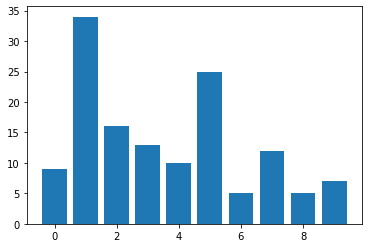

In [351]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Using combinition of dimensionality reduction and clustering

### Credit:
    - https://stats.stackexchange.com/a/256173/276359
    - https://stats.stackexchange.com/a/99191/276359

## With PCA

In [352]:
pca = PCA(n_components=0.60, svd_solver='full')
reduced_data = pca.fit_transform(sentence_embeddings)
reduced_data.shape

(136, 14)

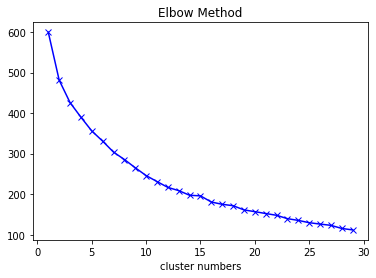

In [353]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [354]:
# Hyperparameter 2
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [356]:
clusters = {}

for i, titles_sentence in enumerate(titles_sentences):
    if km.predict(reduced_data[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]].append(titles_sentence)
    else:
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]] = [titles_sentence]

clusters

{0: ['what is live, attenuated influenza vaccine-laiv (nasal spray)?',
  'what is anthrax?',
  'pcv13 vaccine',
  'what is td vaccine?',
  'dtap vaccine',
  'what typhoid vaccines are available?',
  'chickenpox vaccine',
  'mmr vaccine',
  'what is tdap vaccine?',
  'rabies vaccine',
  'keep your vaccination card',
  'cholera vaccine',
  'what is hpv?',
  'what is hpv vaccine?',
  'shingles vaccine (recombinant)',
  'what is anthrax vaccine?',
  'rotavirus vaccine',
  'what is rabies?',
  'where will my vaccination information be recorded?',
  'what is japanese encephalitis?',
  'what is yellow fever?',
  'shingles vaccine (live):',
  'what is typhoid?',
  'what is inactivated or recombinant influenza vaccine?',
  'how can i prevent yellow fever?',
  'pneumococcal polysaccharide vaccine (ppsv23)',
  'what is hib vaccine?'],
 1: ['other names',
  'browse by generic or brand name:',
  'brand names of combination products',
  'brand names',
  'related topics',
  'combination product'],
 2

<BarContainer object of 10 artists>

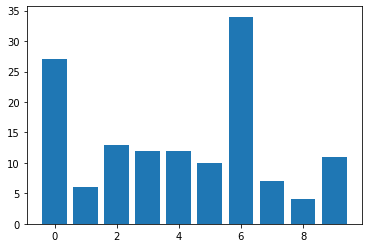

In [357]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## With Normalization - Same results as Cosine similaritis

In [358]:
sentence_embeddings_norm = normalize(sentence_embeddings, axis=1)

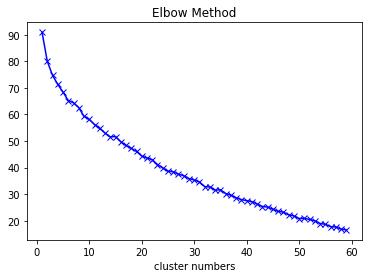

In [359]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(sentence_embeddings_norm)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [360]:
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(sentence_embeddings_norm)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [361]:
clusters = {}

for i, titles_sentence in enumerate(titles_sentences):
    if km.predict(sentence_embeddings_norm[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(sentence_embeddings_norm[i].reshape(-1, 1).T)[0]].append(titles_sentence)
    else:
      clusters[km.predict(sentence_embeddings_norm[i].reshape(-1, 1).T)[0]] = [titles_sentence]

clusters

{0: ['talk with your health care provider', 'tell your doctor if ...'],
 1: [' who should receive the hepatitis b vaccine and when?',
  'some people should not get this vaccine',
  'who should get yellow fever vaccine?',
  'who should not receive the hepatitis b vaccine?',
  'why get vaccinated against hepatitis b?',
  'why get vaccinated?',
  'who should not get yellow fever vaccine?',
  'keep your vaccination card',
  'hpv vaccine—why get vaccinated?',
  'why get vaccinated against hepatitis a?',
  'how can i prevent yellow fever?',
  'who should not receive the cholera vaccine?',
  'who should get hepatitis a vaccine and when?',
  'some babies should not get this vaccine'],
 2: ['why is this medication prescribed?',
  'side effects',
  'drug',
  'what should i do about side effects?',
  'how should this medicine be used?',
  'what side effects can this medication cause?',
  'why is this medicine prescribed?',
  'herbs and supplements',
  'what should i do if i forget a dose?',
  'ot

<BarContainer object of 10 artists>

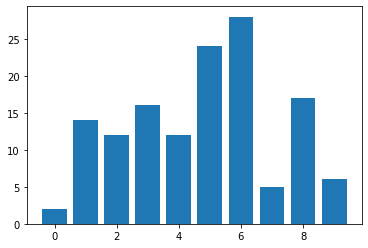

In [362]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## Hierarchical Clustering - Cosine Similarities

In [373]:
model = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='average')
model = model.fit(sentence_embeddings)

In [374]:
clusters = {}

for i, label in enumerate(model.labels_):
    if label in clusters.keys():
      clusters[label].append(titles_sentences[i])
    else:
      clusters[label] = [titles_sentences[i]]

clusters

{0: ['what is live, attenuated influenza vaccine-laiv (nasal spray)?',
  'who should not receive the pcv13 vaccine?',
  'what are the risks of the janssen (johnson and johnson) vaccine?',
  'what is meningococcal vaccine?',
  'who should not get ipv or should wait?',
  'what are the risks of a vaccine reaction?',
  'who should not get or should wait to get laiv?',
  'what are the risks from typhoid vaccine?',
  'who should get anthrax vaccine and when?',
  'who should not get meningococcal vaccine or should wait?',
  'what is anthrax?',
  ' who should receive the hepatitis b vaccine and when?',
  'some people should not get this vaccine',
  'pcv13 vaccine',
  'what is td vaccine?',
  'risks of a vaccine reaction',
  'what are the benefits of the janssen (johnson and johnson) vaccine?',
  'what are the risks from hepatitis b vaccine?',
  'dtap vaccine',
  'what are the risks from anthrax vaccine?',
  'who should get yellow fever vaccine?',
  'what are the risks from ipv?',
  'who should

<BarContainer object of 10 artists>

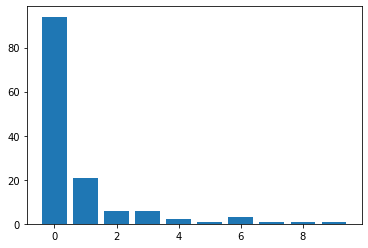

In [375]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## With T-SNE (method = exact)

In [378]:
# Hyperparameter 1 
n_dimention = 15
tsne = TSNE(n_components=n_dimention, method='exact')
reduced_data = tsne.fit_transform(sentence_embeddings)

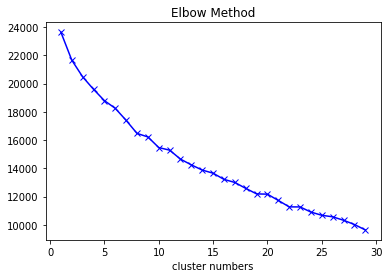

In [379]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [395]:
# Hyperparameter 2
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [396]:
clusters = {}

for i, titles_sentence in enumerate(titles_sentences):
    if km.predict(reduced_data[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]].append(titles_sentence)
    else:
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]] = [titles_sentence]

clusters

{0: ['who should not get or should wait to get laiv?',
  'special instructions',
  ' who should receive the hepatitis b vaccine and when?',
  'what are the risks from hepatitis b vaccine?',
  'what are the risks from ipv?',
  'who should not get meningococcal group b vaccine or should wait?',
  'who should not get tdap vaccine or should wait?',
  'rabies vaccine',
  'what is hpv?',
  'what other information should i know?',
  'what if there is a moderate or severe problem?',
  'where will my vaccination information be recorded?',
  'what is the countermeasures injury compensation program',
  'some people should not get hpv vaccine or should wait',
  'who should not receive the cholera vaccine?',
  'about your treatment',
  'tell your doctor if ...',
  'who should get polio vaccine and when?',
  'what if there is a severe reaction?'],
 1: ['what are the risks of the janssen (johnson and johnson) vaccine?',
  'other names',
  'what are the risks from anthrax vaccine?',
  'what typhoid va

<BarContainer object of 10 artists>

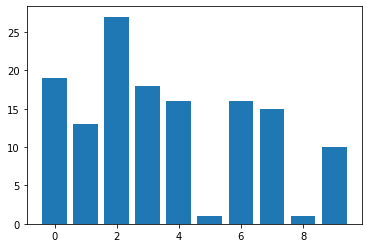

In [397]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

## With T-SNE (method = barnes_hut)

In [398]:
# Hyperparameter 1 
# Barnes–Hut method works only with less than 4 dimensions
n_dimention = 3
tsne = TSNE(n_components=n_dimention, method='barnes_hut')
reduced_data = tsne.fit_transform(sentence_embeddings)

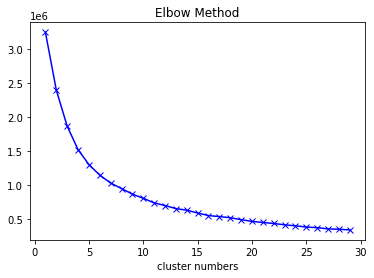

In [399]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [400]:
# Hyperparameter 2
n_clusters = 5

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  5  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [401]:
clusters = {}

for i, titles_sentence in enumerate(titles_sentences):
    if km.predict(reduced_data[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]].append(titles_sentence)
    else:
      clusters[km.predict(reduced_data[i].reshape(-1, 1).T)[0]] = [titles_sentence]

clusters

{0: ['who should not receive the pcv13 vaccine?',
  'who should not get or should wait to get laiv?',
  'who should not get meningococcal vaccine or should wait?',
  'what is td vaccine?',
  'talk with your health care provider',
  'what if there is a serious problem?',
  'who should not get typhoid vaccine or should wait?',
  'who should not get je vaccine or should wait?',
  'some children should not get dtap vaccine or should wait',
  'who should not get tdap vaccine or should wait?',
  'related topics',
  'who should get this hpv vaccine and when?',
  'important warning: ',
  'hpv vaccine—why get vaccinated?',
  'what if there is a moderate or severe problem?',
  'who should not get hib vaccine or should wait?',
  'other uses for this medicine',
  'some people should not get hpv vaccine or should wait',
  'what are the risks from inactivated or recombinant influenza vaccine?',
  'who should get rabies vaccine and when?',
  'who should not receive the cholera vaccine?',
  'injury co

<BarContainer object of 5 artists>

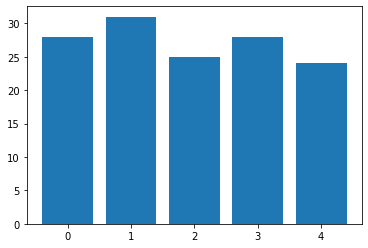

In [402]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])